# Test Warp

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2 as cv

## Common Funcs

In [2]:
## Loading images with integer value intensities, range(0-255)
def load_rgb(path):
    img = cv.imread(path)
    img = img[..., ::-1] / 255.0
    return img

def load_gray(path):
    img = cv.imread(path, 0) / 255.0
    return img

In [3]:
def plot_rgb(img, figsize=None, title=None, xlabel=None, ylabel=None, interpolation=None):
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    
    if interpolation != None:
        plt.imshow(img, interpolation = interpolation)
    else:
        plt.imshow(img)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
        
    plt.show()
    plt.close(fig)

def plot_grayscale(img, figsize=None, title=None, xlabel=None, ylabel=None):
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    
    plt.imshow(img, cmap='gray')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
#     if title != None:        
#         # plt.savefig(f'../imgs/{title}.png', dpi=100, bbox_inches=0) # shit method
#         plt.imsave(f'../imgs/{title}.png', img, cmap='gray')
        
    plt.show()
    plt.close(fig)


## Warp Image

In [4]:
def nearest_neighbour_interpolation(x, y, data, x0, y0):
    xi = np.abs(x-x0).argmin()
    yi = np.abs(y-y0).argmin()
    
    return data[yi, xi]

In [5]:
def warpImage(img, vx, vy, mode='offset'):
    img = np.float32(np.copy(img))
    
    height2, width2, n_channels = img.shape
    height1, width1 = vx.shape
    
    xx, yy = np.meshgrid(np.arange(width2), np.arange(height2))
    # xx = np.float32(xx)
    # yy = np.float32(yy)
    
    XX, YY = np.meshgrid(np.arange(width1), np.arange(height1))
    # XX = np.float32(XX)
    # YY = np.float32(YY)
    
    if mode == 'abs':
        XX = XX + vx
        YY = YY + vy
        
    if mode == 'abs':
        XX = vx
        YY = vy
        
    mask = (XX < 1) | (XX > width) | (YY < 1) | (YY > height2)
    
    
    # XX = np.min(np.max(XX, 1), width2)
    
    XX = np.minimum(np.maximum(XX, 0), width2-1)
    # XX[XX < 0] = 0
    # XX[XX >= width2-1] = width2-1
    
    # YY = np.min(np.max(YY, 1), height2)
    
    YY = np.minimum(np.maximum(YY, 0), width2-1)
    # YY[YY < 0] = 0
    # YY[YY >= height2-1] = height2-1
    
    
    warpI2 = np.zeros((XX.shape[0], XX.shape[1], n_channels))
    
    for i in range(n_channels):
        # foo=interp2(xx, yy, im[:,:,i], XX,YY, 'linear')
        foo = nearest_neighbour_interpolation(xx, yy, img[:,:,i], XX,YY)
        
        foo[mask] = 0.6
        warpI2[:,:,i] = foo
    
    mask = 1 - mask
    
    return warpI2, mask

## Load Images and Landmarks

In [6]:
style_rgb = np.array(load_rgb('../data/inputs/example_2.png'), dtype='float32')
input_rgb = np.array(load_rgb('../data/inputs/input_2.png'), dtype='float32')

In [7]:
style_gray = np.uint8(np.round((load_gray('../data/inputs/example_2.png') * 255)))
input_gray = np.uint8(np.round((load_gray('../data/inputs/input_2.png') * 255)))

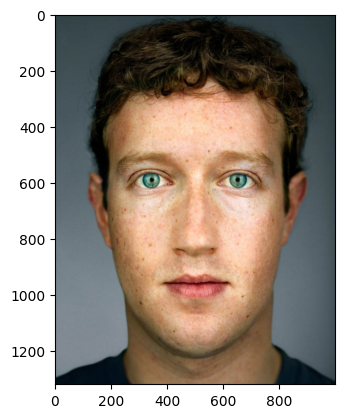

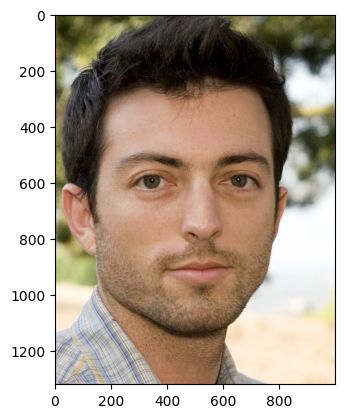

In [8]:
plot_rgb(style_rgb)
plot_rgb(input_rgb)

In [9]:
import dlib

In [10]:
def face_landmarks(img):
    img = np.copy(img)
    
    face_detector = dlib.get_frontal_face_detector()
    landmark_detector = dlib.shape_predictor('../test_data/shape_predictor_68_face_landmarks.dat')
    
    # Asks the detector to fing the bounding boxes of each face
    # The 1 in the second argument indicates that we should upsample the image 1 time
    # This will make everything bigger and allow us to detect more faces
    
    total_faces = face_detector(img, 1)
    
    total_landmarks = []
    
    for k, face in enumerate(total_faces):
        landmarks = landmark_detector(img, face)
        
        for i in range(0, 68):
            x = landmarks.part(i).x
            y = landmarks.part(i).y

            total_landmarks.append([x, y])
            cv.circle(img, (x, y), 4, (255, 0, 0), -1)
            
    total_landmarks = np.array(total_landmarks)
    return img, total_landmarks

In [11]:
style_key, style_landmarks = face_landmarks(style_gray)
input_key, input_landmarks = face_landmarks(input_gray)

# style_corners = [(0, 0), (style_gray.shape[1], 0), (0, style_gray.shape[0]), (style_gray.shape[1], style_gray.shape[0])]
# input_corners = [(0, 0), (input_gray.shape[1], 0), (0, input_gray.shape[0]), (input_gray.shape[1], input_gray.shape[0])]

# for corner in style_corners:
#         style_landmarks = np.vstack((style_landmarks, corner))
        
# for corner in input_corners:
#         input_landmarks = np.vstack((input_landmarks, corner))

In [12]:
# from WrapOperator import wrapOperator

#wrapImg=cv2.imread("../data/inputs/p1.png",0)
import pandas as pd

## Wrap function
# style_landmarks = np.array(pd.read_csv('../data/inputs/example_2.lm', header=None),dtype='float32')
# input_landmarks = np.array(pd.read_csv('../data/inputs/input_2.lm', header=None),dtype='float32')

In [13]:
from scipy.spatial import Delaunay

In [14]:
def triangulation(img, img_landmarks):
    img = np.copy(img)
    
    tri = Delaunay(img_landmarks)
    triangles = img_landmarks[tri.simplices]
    
    for t in triangles:
        cv.line(img, t[0], t[1], (255, 255, 0), 2)
        cv.line(img, t[1], t[2], (255, 255, 0), 2)
        cv.line(img, t[2], t[0], (255, 255, 0), 2)
        
    return img, triangles

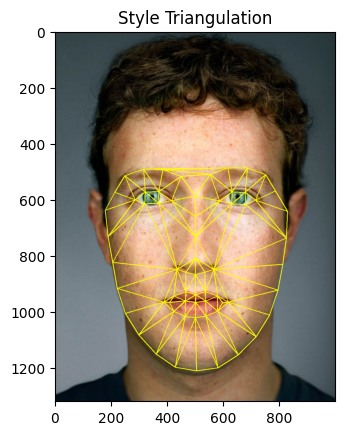

In [15]:
# style_tri, style_triangles = triangulation(np.uint8(np.round(style_rgb * 255)), np.uint8(np.round(style_landmarks)))
style_tri, style_triangles = triangulation(np.uint8(np.round(style_rgb * 255)), style_landmarks)
plot_rgb(style_tri, title='Style Triangulation')

## Redoing Warp

In [16]:
def warp(style_img, input_img, style_lm, input_lm):
    h, w, c = style_img.shape
    trans_coord = np.meshgrid(range(h), range(w), indexing='ij')
    yy, xx = trans_coord[0].astype(np.float64), trans_coord[1].astype(np.float64)  # might need to switch

    xsum = xx * 0.
    ysum = yy * 0.
    wsum = xx * 0.
    
    # dx = np.arange(len(style_lm) - 1)
    dx = np.arange(len(style_lm))
    dy = dx + 1
    
    idx1 = np.array([16, 21, 26, 30, 35, 47])
    dy[idx1] = idx1
    
    
    idx2 = np.array([41, 47, 59, 67])
    dy[idx2] = np.array([36, 42, 48, 60])
    
    # idx2 = np.array([41, 47, 59])
    # dy[idx2] = np.array([36, 42, 48])

    
    # face.con
    for i in dx:
        j = dy[i]
        
        if i == j:
            continue

        # Computes u, v
        p_x1, p_y1 = (style_lm[i, 0], style_lm[i, 1])
        q_x1, q_y1 = (style_lm[j, 0], style_lm[j, 1])
        
        qp_x1 = q_x1 - p_x1
        qp_y1 = q_y1 - p_y1
        
        qpnorm1 = (qp_x1 ** 2 + qp_y1 ** 2) ** 0.5

        u = ((xx - p_x1) * qp_x1 + (yy - p_y1) * qp_y1) / qpnorm1 ** 2
        v = ((xx - p_x1) * -qp_y1 + (yy - p_y1) * qp_x1) / qpnorm1

        # Computes x', y'
        p_x2, p_y2 = (input_lm[i, 0], input_lm[i, 1])
        q_x2, q_y2 = (input_lm[j, 0], input_lm[j, 1])
        
        qp_x2 = q_x2 - p_x2
        qp_y2 = q_y2 - p_y2
        
        qpnorm2 = (qp_x2 ** 2 + qp_y2 ** 2) ** 0.5

        d_x = p_x2 + u * (q_x2 - p_x2) + (v * -qp_y2) / qpnorm2  # X'(x)
        d_y = p_y2 + u * (q_y2 - p_y2) + (v * qp_x2) / qpnorm2  # X'(y)

        # Computes weights
        d1 = ((xx - q_x1) ** 2 + (yy - q_y1) ** 2) ** 0.5
        d2 = ((xx - p_x1) ** 2 + (yy - p_y1) ** 2) ** 0.5
        
        d = np.abs(v)
        
        d[u > 1] = d1[u > 1]
        d[u < 0] = d2[u < 0]
        
        W = (qpnorm1 ** 1 / (10 + d)) ** 1

        wsum += W
        xsum += W * d_x
        ysum += W * d_y

    x_m = xsum / wsum
    y_m = ysum / wsum
    
    vx = xx - x_m
    vy = yy - y_m
    
    vx[x_m < 1] = 0
    vx[x_m > w] = 0
    vy[y_m < 1] = 0
    vy[y_m > h] = 0

    vx = (vx + xx).astype(int)
    vy = (vy + yy).astype(int)
    
    vx[vx >= w] = w - 1
    vy[vy >= h] = h - 1

    warp = np.ones(style_img.shape)
    warp[yy.astype(int), xx.astype(int)] = style_img[vy, vx]
    
    # from skimage.io import imsave
    # imsave('output/transformed.jpg', warp / 255)

    return warp, xx.astype(int), yy.astype(int), vx, vy

In [17]:
warp, xx, yy, vx, vy = warp(style_img=style_rgb, input_img=input_rgb,style_lm=style_landmarks,input_lm=input_landmarks)

In [18]:
# wrap_style= warp / 255
wrap_style = (warp - np.min(warp)) / (np.max(warp) - np.min(warp))

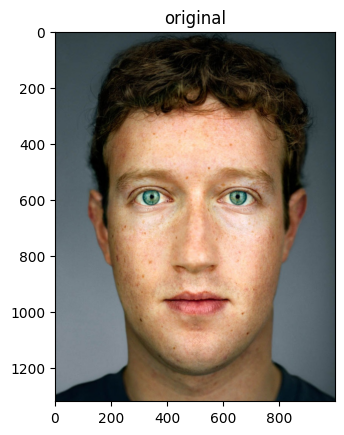

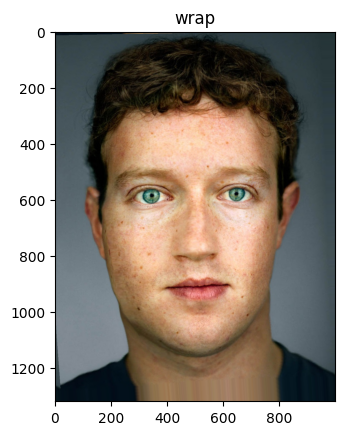

In [19]:
plot_rgb(style_rgb, title='original')
plot_rgb(wrap_style, title='warp')